In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd

import re

## Features 

In [2]:
import re

indexes = []
features = []
with open('../homework2_exercise2/data/features', 'r') as f:
    for line in f.readlines():
        index, *feat = line.split(':')
        feat = ''.join(feat)
        feat = re.findall('"([^\"]*)"', feat)
        indexes.append(index)
    
        
        feat += [f.split('_')[0] for f in feat]
        feat = list(set(feat))
        
        features.append(feat)

In [3]:
one_hot = MultiLabelBinarizer()
mhe = one_hot.fit_transform(features)
df = pd.DataFrame(mhe)

In [4]:
df.rename(columns=lambda x: f'feat_{x}', inplace=True)
df = df.T.drop_duplicates().T
df = df.astype(bool)
df['theorem'] = indexes

In [5]:
del mhe
del features
del indexes

# Dataset

## Ones

In [6]:
indexes_train = []
premises = []

ones = []

with open('../homework2_exercise2/data/dependencies_train', 'r') as f:
    for line in f.readlines():
        index, *prem = line.split(':')
        prem = ''.join(prem).split()
        
        indexes_train.append(index)
        premises.append(prem)
        
        for p in prem:
            ones.append((index, p))

In [7]:
ones_df = pd.DataFrame(ones, columns=['theorem', 'premise']).drop_duplicates()

In [8]:
del ones
del premises
del indexes_train

## Zeros

In [9]:
chronology = pd.read_csv('../homework2_exercise2/data/chronology_backup', squeeze=True, names=['chronology'])
def get_available_theorems(name):
    return chronology.loc[:(chronology == name).argmax()-1]

In [10]:
used_premises = ones_df.groupby('theorem')['premise'].unique()

In [12]:
FALSE_EXAMPLES_RATIO = 2

dataset_zeros = []
for theorem, theorem_premises in ones_df.groupby('theorem')['premise']:
    available_theorems = get_available_theorems(theorem)
    zero_premises = np.setdiff1d(available_theorems, theorem_premises)
    
    zeros_chosen = zero_premises[np.random.randint(0, len(zero_premises), FALSE_EXAMPLES_RATIO * theorem_premises.shape[0])]
    dataset_zeros += list(zip(
        [theorem] * len(zeros_chosen),
        zeros_chosen
    ))

/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
zeros_df = pd.DataFrame(dataset_zeros, columns=['theorem', 'premise'])

In [14]:
del dataset_zeros
del used_premises

##  Merging

In [15]:
zeros_df['useful'] = 0
ones_df['useful'] = 1
df_train = pd.concat([zeros_df, ones_df])

In [16]:
del zeros_df
del ones_df

In [17]:
def map_features(thm_prem_pairs):
    df_values = pd.merge(
        thm_prem_pairs, df,
        left_on=['theorem'],
        right_on=['theorem']
    )
    df_values = pd.merge(
        df_values, df,
        left_on=['premise'],
        right_on=['theorem'],
        suffixes=('_prem', '_thm')
    ).drop(['theorem_thm'], axis=1).rename(columns={'theorem_prem': 'theorem'})
    return df_values

In [18]:
df_train = map_features(df_train)
df_train.head()

,theorem,premise,useful,feat_0_prem,feat_1_prem,feat_2_prem,feat_3_prem,feat_4_prem,feat_6_prem,feat_7_prem,...,feat_10348_thm,feat_10353_thm,feat_10355_thm,feat_10358_thm,feat_10361_thm,feat_10362_thm,feat_10365_thm,feat_10368_thm,feat_10373_thm,feat_10376_thm
0,t100_tmap_1,dt_u1_waybel_0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,t119_tmap_1,dt_u1_waybel_0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,t14_waybel_9,dt_u1_waybel_0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,t15_waybel_9,dt_u1_waybel_0,1,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,t35_waybel_9,dt_u1_waybel_0,1,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


# Training 

In [19]:
import lightgbm as lgb

In [26]:
# train test split
from sklearn.model_selection import train_test_split
train_theorems, test_theorems = train_test_split(df_train['theorem'].unique(), shuffle=True, train_size=0.95)

train = df_train['theorem'].isin(train_theorems)
test = df_train['theorem'].isin(test_theorems)

features = list(df_train.columns.drop(['theorem', 'premise', 'useful']))
y_name = 'useful'

In [ ]:
df_train.drop(['theorem', 'premise'], axis=1).to_csv('train_lgbm.csv', index=False)

### lgbm

In [50]:
train_data = lgb.Dataset(df_train[train][features], df_train[train][y_name],
                        #categorical_feature=features,
                        free_raw_data=False
                        )
test_data = lgb.Dataset(df_train[test][features], df_train[test][y_name],
                        #categorical_feature=features,
                        free_raw_data=False
                        )

In [51]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 60,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'lambda_l2': 0.06,
    'verbose': 1,
    'threads': 6,
    'num_boost_round': 4000,
    'early_stopping_rounds': 200
}
model = lgb.train(
    parameters,
    train_data,
    valid_sets=test_data
)

[1]	valid_0's auc: 0.710736
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's auc: 0.766732
[3]	valid_0's auc: 0.788077
[4]	valid_0's auc: 0.787681
[5]	valid_0's auc: 0.795048
[6]	valid_0's auc: 0.800169
[7]	valid_0's auc: 0.804511
[8]	valid_0's auc: 0.809452
[9]	valid_0's auc: 0.810072
[10]	valid_0's auc: 0.814141
[11]	valid_0's auc: 0.81523
[12]	valid_0's auc: 0.819451
[13]	valid_0's auc: 0.81702
[14]	valid_0's auc: 0.821553
[15]	valid_0's auc: 0.824239
[16]	valid_0's auc: 0.828019
[17]	valid_0's auc: 0.830888
[18]	valid_0's auc: 0.830945
[19]	valid_0's auc: 0.834749
[20]	valid_0's auc: 0.837001
[21]	valid_0's auc: 0.840184
[22]	valid_0's auc: 0.842096
[23]	valid_0's auc: 0.843362
[24]	valid_0's auc: 0.843891
[25]	valid_0's auc: 0.845569
[26]	valid_0's auc: 0.846884
[27]	valid_0's auc: 0.848197
[28]	valid_0's auc: 0.848454
[29]	valid_0's auc: 0.85014
[30]	valid_0's auc: 0.851604
[31]	valid_0's auc: 0.851985
[32]	valid_0's auc: 0.852758
[33]	valid_0's auc: 0

[283]	valid_0's auc: 0.922231
[284]	valid_0's auc: 0.922201
[285]	valid_0's auc: 0.922173
[286]	valid_0's auc: 0.92218
[287]	valid_0's auc: 0.922268
[288]	valid_0's auc: 0.922365
[289]	valid_0's auc: 0.922501
[290]	valid_0's auc: 0.922535
[291]	valid_0's auc: 0.922659
[292]	valid_0's auc: 0.922677
[293]	valid_0's auc: 0.922853
[294]	valid_0's auc: 0.922862
[295]	valid_0's auc: 0.922848
[296]	valid_0's auc: 0.92288
[297]	valid_0's auc: 0.922913
[298]	valid_0's auc: 0.92297
[299]	valid_0's auc: 0.923022
[300]	valid_0's auc: 0.923042
[301]	valid_0's auc: 0.923023
[302]	valid_0's auc: 0.923102
[303]	valid_0's auc: 0.923148
[304]	valid_0's auc: 0.923144
[305]	valid_0's auc: 0.923226
[306]	valid_0's auc: 0.923264
[307]	valid_0's auc: 0.923368
[308]	valid_0's auc: 0.9235
[309]	valid_0's auc: 0.923611
[310]	valid_0's auc: 0.923709
[311]	valid_0's auc: 0.923729
[312]	valid_0's auc: 0.923855
[313]	valid_0's auc: 0.923916
[314]	valid_0's auc: 0.923925
[315]	valid_0's auc: 0.923958
[316]	valid_0's

[560]	valid_0's auc: 0.932735
[561]	valid_0's auc: 0.932762
[562]	valid_0's auc: 0.932799
[563]	valid_0's auc: 0.932794
[564]	valid_0's auc: 0.932809
[565]	valid_0's auc: 0.932821
[566]	valid_0's auc: 0.932885
[567]	valid_0's auc: 0.932873
[568]	valid_0's auc: 0.932898
[569]	valid_0's auc: 0.932938
[570]	valid_0's auc: 0.932929
[571]	valid_0's auc: 0.932902
[572]	valid_0's auc: 0.93295
[573]	valid_0's auc: 0.932972
[574]	valid_0's auc: 0.932985
[575]	valid_0's auc: 0.932997
[576]	valid_0's auc: 0.933048
[577]	valid_0's auc: 0.933046
[578]	valid_0's auc: 0.933125
[579]	valid_0's auc: 0.933161
[580]	valid_0's auc: 0.93316
[581]	valid_0's auc: 0.933206
[582]	valid_0's auc: 0.933259
[583]	valid_0's auc: 0.933363
[584]	valid_0's auc: 0.933397
[585]	valid_0's auc: 0.933419
[586]	valid_0's auc: 0.93347
[587]	valid_0's auc: 0.933523
[588]	valid_0's auc: 0.93356
[589]	valid_0's auc: 0.933631
[590]	valid_0's auc: 0.93369
[591]	valid_0's auc: 0.933707
[592]	valid_0's auc: 0.933704
[593]	valid_0's

[847]	valid_0's auc: 0.936889
[848]	valid_0's auc: 0.936888
[849]	valid_0's auc: 0.936917
[850]	valid_0's auc: 0.936943
[851]	valid_0's auc: 0.937014
[852]	valid_0's auc: 0.937037
[853]	valid_0's auc: 0.937046
[854]	valid_0's auc: 0.937105
[855]	valid_0's auc: 0.937115
[856]	valid_0's auc: 0.937102
[857]	valid_0's auc: 0.937151
[858]	valid_0's auc: 0.937137
[859]	valid_0's auc: 0.93712
[860]	valid_0's auc: 0.937125
[861]	valid_0's auc: 0.937122
[862]	valid_0's auc: 0.937122
[863]	valid_0's auc: 0.93711
[864]	valid_0's auc: 0.937106
[865]	valid_0's auc: 0.937069
[866]	valid_0's auc: 0.937087
[867]	valid_0's auc: 0.937104
[868]	valid_0's auc: 0.937114
[869]	valid_0's auc: 0.937135
[870]	valid_0's auc: 0.937187
[871]	valid_0's auc: 0.937153
[872]	valid_0's auc: 0.937203
[873]	valid_0's auc: 0.937229
[874]	valid_0's auc: 0.937261
[875]	valid_0's auc: 0.937244
[876]	valid_0's auc: 0.93725
[877]	valid_0's auc: 0.937265
[878]	valid_0's auc: 0.937263
[879]	valid_0's auc: 0.937238
[880]	valid_0

[1128]	valid_0's auc: 0.939587
[1129]	valid_0's auc: 0.939567
[1130]	valid_0's auc: 0.939596
[1131]	valid_0's auc: 0.939607
[1132]	valid_0's auc: 0.939618
[1133]	valid_0's auc: 0.939665
[1134]	valid_0's auc: 0.939695
[1135]	valid_0's auc: 0.939689
[1136]	valid_0's auc: 0.939688
[1137]	valid_0's auc: 0.93969
[1138]	valid_0's auc: 0.939704
[1139]	valid_0's auc: 0.939695
[1140]	valid_0's auc: 0.939726
[1141]	valid_0's auc: 0.939746
[1142]	valid_0's auc: 0.939777
[1143]	valid_0's auc: 0.939806
[1144]	valid_0's auc: 0.939869
[1145]	valid_0's auc: 0.939891
[1146]	valid_0's auc: 0.939904
[1147]	valid_0's auc: 0.939912
[1148]	valid_0's auc: 0.939939
[1149]	valid_0's auc: 0.939962
[1150]	valid_0's auc: 0.939983
[1151]	valid_0's auc: 0.939986
[1152]	valid_0's auc: 0.940003
[1153]	valid_0's auc: 0.940029
[1154]	valid_0's auc: 0.940045
[1155]	valid_0's auc: 0.940059
[1156]	valid_0's auc: 0.940068
[1157]	valid_0's auc: 0.940095
[1158]	valid_0's auc: 0.940099
[1159]	valid_0's auc: 0.940109
[1160]	va

[1398]	valid_0's auc: 0.94165
[1399]	valid_0's auc: 0.941651
[1400]	valid_0's auc: 0.941662
[1401]	valid_0's auc: 0.941688
[1402]	valid_0's auc: 0.941699
[1403]	valid_0's auc: 0.941588
[1404]	valid_0's auc: 0.941533
[1405]	valid_0's auc: 0.941536
[1406]	valid_0's auc: 0.941494
[1407]	valid_0's auc: 0.94148
[1408]	valid_0's auc: 0.94147
[1409]	valid_0's auc: 0.941459
[1410]	valid_0's auc: 0.941475
[1411]	valid_0's auc: 0.941485
[1412]	valid_0's auc: 0.941476
[1413]	valid_0's auc: 0.941431
[1414]	valid_0's auc: 0.941402
[1415]	valid_0's auc: 0.941401
[1416]	valid_0's auc: 0.941314
[1417]	valid_0's auc: 0.941311
[1418]	valid_0's auc: 0.941306
[1419]	valid_0's auc: 0.941309
[1420]	valid_0's auc: 0.941318
[1421]	valid_0's auc: 0.941318
[1422]	valid_0's auc: 0.941313
[1423]	valid_0's auc: 0.94132
[1424]	valid_0's auc: 0.941348
[1425]	valid_0's auc: 0.94135
[1426]	valid_0's auc: 0.941348
[1427]	valid_0's auc: 0.941336
[1428]	valid_0's auc: 0.941345
[1429]	valid_0's auc: 0.941411
[1430]	valid_

[1676]	valid_0's auc: 0.943072
[1677]	valid_0's auc: 0.943085
[1678]	valid_0's auc: 0.943087
[1679]	valid_0's auc: 0.943137
[1680]	valid_0's auc: 0.943181
[1681]	valid_0's auc: 0.943191
[1682]	valid_0's auc: 0.943191
[1683]	valid_0's auc: 0.94319
[1684]	valid_0's auc: 0.943198
[1685]	valid_0's auc: 0.943197
[1686]	valid_0's auc: 0.943183
[1687]	valid_0's auc: 0.94319
[1688]	valid_0's auc: 0.943182
[1689]	valid_0's auc: 0.943185
[1690]	valid_0's auc: 0.943187
[1691]	valid_0's auc: 0.943166
[1692]	valid_0's auc: 0.943167
[1693]	valid_0's auc: 0.943123
[1694]	valid_0's auc: 0.943117
[1695]	valid_0's auc: 0.943132
[1696]	valid_0's auc: 0.943139
[1697]	valid_0's auc: 0.943129
[1698]	valid_0's auc: 0.943112
[1699]	valid_0's auc: 0.94312
[1700]	valid_0's auc: 0.943132
[1701]	valid_0's auc: 0.94314
[1702]	valid_0's auc: 0.943109
[1703]	valid_0's auc: 0.943093
[1704]	valid_0's auc: 0.943091
[1705]	valid_0's auc: 0.943093
[1706]	valid_0's auc: 0.943087
[1707]	valid_0's auc: 0.943078
[1708]	valid

[1958]	valid_0's auc: 0.944254
[1959]	valid_0's auc: 0.94424
[1960]	valid_0's auc: 0.944265
[1961]	valid_0's auc: 0.94428
[1962]	valid_0's auc: 0.94429
[1963]	valid_0's auc: 0.94432
[1964]	valid_0's auc: 0.944285
[1965]	valid_0's auc: 0.9443
[1966]	valid_0's auc: 0.944331
[1967]	valid_0's auc: 0.944328
[1968]	valid_0's auc: 0.944375
[1969]	valid_0's auc: 0.944408
[1970]	valid_0's auc: 0.944439
[1971]	valid_0's auc: 0.94447
[1972]	valid_0's auc: 0.944465
[1973]	valid_0's auc: 0.944463
[1974]	valid_0's auc: 0.944465
[1975]	valid_0's auc: 0.944472
[1976]	valid_0's auc: 0.944447
[1977]	valid_0's auc: 0.944434
[1978]	valid_0's auc: 0.944434
[1979]	valid_0's auc: 0.944447
[1980]	valid_0's auc: 0.944426
[1981]	valid_0's auc: 0.944433
[1982]	valid_0's auc: 0.944446
[1983]	valid_0's auc: 0.944452
[1984]	valid_0's auc: 0.944467
[1985]	valid_0's auc: 0.944452
[1986]	valid_0's auc: 0.944418
[1987]	valid_0's auc: 0.944421
[1988]	valid_0's auc: 0.944411
[1989]	valid_0's auc: 0.944421
[1990]	valid_0'

[2228]	valid_0's auc: 0.945345
[2229]	valid_0's auc: 0.945341
[2230]	valid_0's auc: 0.945344
[2231]	valid_0's auc: 0.945352
[2232]	valid_0's auc: 0.945353
[2233]	valid_0's auc: 0.945373
[2234]	valid_0's auc: 0.945374
[2235]	valid_0's auc: 0.945351
[2236]	valid_0's auc: 0.945335
[2237]	valid_0's auc: 0.945339
[2238]	valid_0's auc: 0.945335
[2239]	valid_0's auc: 0.945334
[2240]	valid_0's auc: 0.945325
[2241]	valid_0's auc: 0.945335
[2242]	valid_0's auc: 0.945349
[2243]	valid_0's auc: 0.94534
[2244]	valid_0's auc: 0.945349
[2245]	valid_0's auc: 0.945351
[2246]	valid_0's auc: 0.945335
[2247]	valid_0's auc: 0.945328
[2248]	valid_0's auc: 0.945316
[2249]	valid_0's auc: 0.945296
[2250]	valid_0's auc: 0.945307
[2251]	valid_0's auc: 0.945315
[2252]	valid_0's auc: 0.94531
[2253]	valid_0's auc: 0.94531
[2254]	valid_0's auc: 0.945329
[2255]	valid_0's auc: 0.94533
[2256]	valid_0's auc: 0.945311
[2257]	valid_0's auc: 0.945295
[2258]	valid_0's auc: 0.94529
[2259]	valid_0's auc: 0.945304
[2260]	valid_

### rf

In [48]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=80, n_jobs=-1)
model.fit(df_train[train][features], df_train[train][y_name])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df_train[test][y_name], model.predict_proba(df_train[test][features])[:, 1])

0.9365508414282976

## Production model

In [52]:
train_data = lgb.Dataset(df_train[features], df_train[y_name],
                        #categorical_feature=features,
                        free_raw_data=False
                        )

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
#   'num_leaves': 60,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'lambda_l2': 0.06,
    'verbose': 1,
    'threads': 6,
    'num_boost_round': 2550
}
model = lgb.train(
    parameters,
    train_data
)

In [61]:
train_data = lgb.Dataset(df_train[features], df_train[y_name],
                        #categorical_feature=features,
                        free_raw_data=False
                        )

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
   'num_leaves': 60,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'lambda_l2': 0.06,
    'verbose': 1,
    'threads': 6,
    'num_boost_round': 2550
}
model_small = lgb.train(
    parameters,
    train_data
)

In [68]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, n_jobs=-1)
model.fit(df_train[features], df_train[y_name])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Suggested premises for new conjectures

In [53]:
conjs = pd.read_csv('../homework2_exercise2/data/conjectures_test', squeeze=True, names=['conjecture'])

In [69]:
#usefulness_threshold = 0.8
def get_premises(conj):
    premises = get_available_theorems(conj)
    premises.name = 'premise'
    premises = premises.to_frame()
    premises['theorem'] = conj
    df_values = map_features(premises)
    
    df_X = df_values.drop(['theorem', 'premise'], axis=1)
    
    #premises['useful'] = (model.predict(df_X) + model_small.predict(df_X)) / 2
    premises['useful'] = model.predict(df_X)
    premises = premises.sort_values(by='useful', ascending=False)
    return premises['premise'].head(60)
    #return premises[premises['useful'] > usefulness_threshold]['premise']

In [55]:
import sys
sys.path.append('..')
from homework2_exercise2.run_E_prover import find_proof

In [70]:
statements_path = '../homework2_exercise2/data/statements'
dirpath = '../homework2_exercise2/new_conjectures/'
with open(statements_path, 'r') as f:
    statements_lines = f.read().splitlines()
statements = {}
for l in statements_lines:
    statements[l.split(',')[0].replace('fof(', '')] = l


In [71]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
conj_results = []
proved_cnt = 0
for i, conj_name in enumerate(conjs):
    premises_for_conj = get_premises(conj_name)
    proved = find_proof(conj_name, premises_for_conj, statements, dirpath)
    if i % 10 == 0:
        print('=' * 20)
        print(f'i={i}, proved {proved_cnt}')
    
    if proved:
        proved_cnt += 1
    conj_results.append((conj_name, proved))

Proof of conjecture t34_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t34_waybel_0.E_output 
i=0, proved 0
Proof of conjecture t5_funct_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t5_funct_2.E_output 
Proof of conjecture t57_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t57_tmap_1.E_output 
Proof of conjecture t52_pre_topc NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t52_pre_topc.E_output 
Proof of conjecture t72_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t72_funct_1.E_output 
Proof of conjecture t84_enumset1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t84_enumset1.E_output
Proof of conjecture t172_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t172_funct_1.E_output 
Proof of conjecture t12_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t12_funct_1.E_output
Proo

Proof of conjecture t25_relset_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t25_relset_1.E_output
Proof of conjecture t75_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t75_zfmisc_1.E_output 
Proof of conjecture t137_enumset1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t137_enumset1.E_output 
Proof of conjecture t90_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t90_xboole_1.E_output
Proof of conjecture t140_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t140_relat_1.E_output 
Proof of conjecture t54_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t54_funct_1.E_output 
i=70, proved 22
Proof of conjecture t18_lattices FOUND. Output in file ../homework2_exercise2/new_conjectures/t18_lattices.E_output
Proof of conjecture t17_waybel_7 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t17_waybel_7.E_output 
P

Proof of conjecture t12_wellord2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t12_wellord2.E_output 
i=130, proved 31
Proof of conjecture t108_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t108_xboole_1.E_output
Proof of conjecture t38_tops_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t38_tops_2.E_output 
Proof of conjecture t50_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t50_tops_1.E_output 
Proof of conjecture t63_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t63_funct_1.E_output 
Proof of conjecture t8_lattice3 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t8_lattice3.E_output 
Proof of conjecture t40_tmap_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t40_tmap_1.E_output
Proof of conjecture t38_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t38_yellow_0.E_output 
Pro

Proof of conjecture t21_wellord1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t21_wellord1.E_output 
Proof of conjecture t111_xboole_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t111_xboole_1.E_output 
Proof of conjecture t63_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t63_waybel_0.E_output 
Proof of conjecture t61_tex_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t61_tex_2.E_output 
Proof of conjecture t18_wellord1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t18_wellord1.E_output 
Proof of conjecture t95_enumset1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t95_enumset1.E_output
i=200, proved 45
Proof of conjecture t17_yellow_6 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t17_yellow_6.E_output 
Proof of conjecture t45_ordinal1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t45_o

In [66]:
pd.DataFrame(conj_results)[1].mean()

0.402

In [67]:
pd.DataFrame(conj_results).to_csv('results_mean.csv')

In [22]:
conj_name

NameError: name 'conj_name' is not defined

In [78]:
premises_for_conj.shape

(4,)

In [55]:
conj_name in premises_for_conj

False

In [59]:
chronology[(chronology == 't5_funct_2')]

1478    t5_funct_2
Name: chronology, dtype: object

In [57]:
(premises_for_conj == 't5_funct_2').sum()

1

In [53]:
conj_name

't5_funct_2'

In [48]:
a.shape

(195, 3)

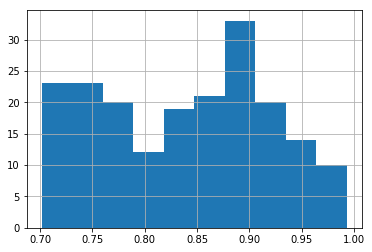

In [49]:
a['useful'].hist()

In [45]:
a['useful'].quantile(0.95)


0.6479658909399986

In [32]:
available_premises_for_conj(conjs[0]).to_frame()

/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


,premises
0,dt_k5_xboole_0
1,dt_k4_xboole_0
2,idempotence_k2_xboole_0
3,d3_xboole_0
4,commutativity_k5_xboole_0
5,d5_xboole_0
6,d6_xboole_0
7,antisymmetry_r2_hidden
8,commutativity_k2_xboole_0
9,dt_k2_xboole_0


In [57]:
available_premises_for_conj('t57_tmap_1').tail()

/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


4561          fc6_yellow19
4562    dt_o_2_13_yellow19
4563          t38_yellow19
4564          t34_waybel_0
4565            t5_funct_2
dtype: object

In [2]:
from sklearn.model_selection import train_test_split

In [4]:
import pandas as pd

In [11]:
df = pd.DataFrame([[1,2], [1,3],[3,5], [2,4]])
df.head()

,0,1
0,1,2
1,1,3
2,3,5
3,2,4


In [26]:
split = train_test_split(df[0].unique(), shuffle=True)

In [27]:
df[df[0].isin(split[0])]

,0,1
2,3,5
3,2,4


In [28]:
df

,0,1
0,1,2
1,1,3
2,3,5
3,2,4
